# Prescision in ML models

A brief exploration of how to calculate the prescision of various ML models.


In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,Lasso,LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,train_test_split,KFold
from sklearn.metrics import classification_report,confusion_matrix, mean_squared_error,roc_curve
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')


In [2]:
# import dataset
#Melbourne Housing data taken from Kaggle
df = pd.read_csv('Melbourne_housing_FULL.csv')


In [3]:
#get rid of anything that is a nan
df=df.dropna(axis=0, how='any')
df.describe()
#print (df.columns)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,8887.000000,8.887000e+03,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
mean,3.098909,1.092902e+06,11.199887,3111.662653,3.078204,1.646450,1.692247,523.480365,149.309477,1965.753348,-37.804501,144.991393,7475.940137
std,0.963786,6.793819e+05,6.813402,112.614268,0.966269,0.721611,0.975464,1061.324228,87.925580,37.040876,0.090549,0.118919,4375.024364
min,1.000000,1.310000e+05,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000,-38.174360,144.423790,249.000000
25%,2.000000,6.410000e+05,6.400000,3044.000000,2.000000,1.000000,1.000000,212.000000,100.000000,1945.000000,-37.858560,144.920000,4382.500000
50%,3.000000,9.000000e+05,10.200000,3084.000000,3.000000,2.000000,2.000000,478.000000,132.000000,1970.000000,-37.798700,144.998500,6567.000000
75%,4.000000,1.345000e+06,13.900000,3150.000000,4.000000,2.000000,2.000000,652.000000,180.000000,2000.000000,-37.748945,145.064560,10331.000000
max,12.000000,9.000000e+06,47.400000,3977.000000,12.000000,9.000000,10.000000,42800.000000,3112.000000,2019.000000,-37.407200,145.526350,21650.000000


# Accuracy in Classification Models

In classification models we try and assign a datapoint to a class given a particular model. Accuracy is determined via a test set by comparing predicted outcomes to the true values.

As an example lets try classifying properties into their types by their number of rooms and price.

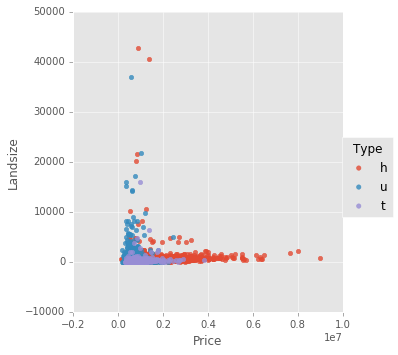

In [4]:
#plot data


sns.lmplot( x="Price", y="Landsize", data=df, fit_reg=False, hue='Type', legend=True)
 
plt.show()

due to the large overlap we want to exclude all points of the t class from further analysis
(Ran it with 't' type in before but it had a hard time predicting anything and it was interefering with the rest of the model)

In [5]:
df = df[df['Type']!='t']
# means we have to make it drop all nans again
df = df.dropna(axis=0, how='any')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8165 entries, 2 to 34856
Data columns (total 21 columns):
Suburb           8165 non-null object
Address          8165 non-null object
Rooms            8165 non-null int64
Type             8165 non-null object
Price            8165 non-null float64
Method           8165 non-null object
SellerG          8165 non-null object
Date             8165 non-null object
Distance         8165 non-null float64
Postcode         8165 non-null float64
Bedroom2         8165 non-null float64
Bathroom         8165 non-null float64
Car              8165 non-null float64
Landsize         8165 non-null float64
BuildingArea     8165 non-null float64
YearBuilt        8165 non-null float64
CouncilArea      8165 non-null object
Lattitude        8165 non-null float64
Longtitude       8165 non-null float64
Regionname       8165 non-null object
Propertycount    8165 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 1.4+ MB


In [6]:
y =df['Type'].values
#double check all 't' types have been removed
print(pd.unique(y))

X = df[['Rooms','Price','Distance','YearBuilt','Landsize','BuildingArea']].values

#create training and testing datasets
# Problem with this is that it is dependant exactly how the split between train and test is choosen

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=123, stratify=y)

['h' 'u']


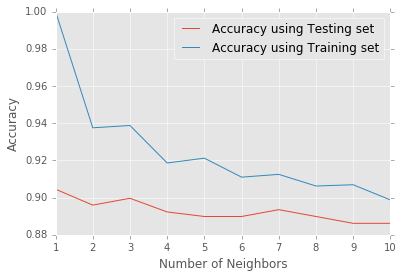

In [7]:
# The number of neighbours is important
# Here we loop over several numbers of k to determine the optimum number of neighbours
# the optimum number of neighbours is where we optimize for both the training and testing accuracy

neighbors = np.arange(1,11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

plt.plot(neighbors, test_accuracy, label = 'Accuracy using Testing set')
plt.plot(neighbors, train_accuracy, label = 'Accuracy using Training set')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

High accuracy doesn't neccecarily mean one has build a particularly fantastic model.
If for example the dataset was on people beign tested on an increadibly rare disease and out of a hundred people only one has the disese I would still be able to achieve 99% accuracy by saying that noone in the test group has the disease.
To avoid that class imbalances are used.

# Logistic regression
uses ROC curve to determine accuracy

We first have to convert our feature into a dummy variable as it won't be accepted in its current format

In [8]:
y_dummy = pd.get_dummies(y)

#checking that h and u got converted into a dummy variable
pd.unique(y_dummy['h'])

array([1., 0.])

In [9]:
#make new input for the train test split using the newly added dummy variables
y_dummy= y_dummy['h']

X_train, X_test, y_train, y_test = train_test_split(X, y_dummy, test_size = 0.3, random_state=123)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

        0.0       0.82      0.47      0.60       484
        1.0       0.88      0.98      0.93      1966

avg / total       0.87      0.88      0.86      2450



[0.73010893 0.82360311 0.94794121 ... 0.9171646  0.62181356 0.78997367]


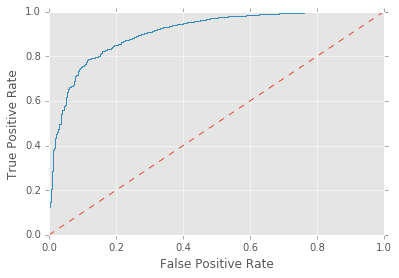

In [11]:
y_predict_prob = logreg.predict_proba(X_test)[:,1]
print (y_predict_prob)

# generating the false positive rate, true positive rate as well as threshholds
fpr, tpr, threshholds = roc_curve(y_test, y_predict_prob)


plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The better the model the larger the area under the curve.
In perfect conditions this would be 1.0. When the area under the curve is 0.5 the model is completely random. The value should never fall below 0.5 as this would indicate something wrong is happening somewhere in the process.

# Prescision in regression models
In regression models we will always try and minimize an error function.
Most commonly this is R$^{2}$ though that is dependant on the problem and field.
K-fold cross validation is used to adress possible biases being introduced while splitting the data. It is however computationally expensive.
A model can further be improoved by using regularization (Lasso/Ridge in sklearn), which can help prevent over or underfitting.

In [14]:
# using new set of inputs for linear regression
y_lin = df['Price'].values
X_lin = df[['Rooms','Distance','YearBuilt','Landsize','BuildingArea']].values

reg = LinearRegression()
kfold = KFold(n_splits=10, random_state=42)
cv_scores = cross_val_score(reg,X_lin,y_lin,cv=kfold)

#cross validation scpres plus error
print(cv_scores.mean(), cv_scores.std())

0.4691444235023855 0.0709759773966132


with a value of <0.5 this presents a rather poor fit